In [14]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
 <a href="javascript:code_toggle()">expand</a>.''')

In [15]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
pd.options.display.max_rows = 999
import numpy as np
import statsmodels.api as sm
from patsy import dmatrices

In [16]:
FeatureTrain = pd.read_csv('./data/dengue_features_train.csv',parse_dates = ['week_start_date'])
TargetTrain = pd.read_csv('./data/dengue_labels_train.csv' )
FeatureTest = pd.read_csv('./data/dengue_features_test.csv',parse_dates = ['week_start_date'])
Answersheet = pd.read_csv('./data/submission_format.csv' )

#                                  Presentation Data Exploration

In [17]:
panel = TargetTrain.merge(FeatureTrain,on = ['city','year','weekofyear'] ,how = 'outer') 
 
kelvin = ['reanalysis_air_temp_k', 'reanalysis_avg_temp_k',   \
          'reanalysis_max_air_temp_k','reanalysis_min_air_temp_k','reanalysis_dew_point_temp_k']
panel.loc[:,kelvin] = panel.loc[:,kelvin]-273.15# kelvin to C
FeatureTest.loc[:,kelvin] =FeatureTest.loc[:,kelvin]-273.15# kelvin to C
panel.columns
timeid = ['year', 'weekofyear']
green = ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']
precipitation  =['precipitation_amt_mm','reanalysis_sat_precip_amt_mm','station_precip_mm','reanalysis_precip_amt_kg_per_m2',]
avg_temp = ['reanalysis_air_temp_k', 'reanalysis_avg_temp_k',  'station_avg_temp_c' ]
min_temp = ['station_min_temp_c','reanalysis_min_air_temp_k']
max_temp = ['station_max_temp_c','reanalysis_max_air_temp_k']
dtr =  ['reanalysis_tdtr_k', 'station_diur_temp_rng_c']
humid = ['reanalysis_dew_point_temp_k','reanalysis_specific_humidity_g_per_kg', 'reanalysis_relative_humidity_percent']
selected = humid + dtr + max_temp +min_temp +avg_temp +precipitation +timeid+green + ['city','total_cases','week_start_date']
features_selected= humid + dtr + max_temp +min_temp +avg_temp +precipitation +timeid+green  
panel = panel.loc[:,selected]

 
 


In [18]:
 
def get_data_panel(panel,city_name):
    panel_train =  panel.loc[panel.city == city_name].interpolate()  .set_index('week_start_date').copy().drop(['city'],axis = 1).copy()
    
    panel_test = FeatureTest.loc[FeatureTest.city == city_name].interpolate().set_index('week_start_date').copy().drop('city',axis = 1)
    panel_test['total_cases'] = np.nan 
    train_len = len(panel_test['total_cases'])
    panel = pd.concat([panel_train,panel_test],sort = False)
    
    
    panel['green_s']  = panel.loc[:,green[:2]].mean(1)
    panel['green_n']  = panel.loc[:,green[2:]].mean(1) 
    panel['green']  = panel.loc[:,green ].mean(1) 

    panel  = panel 
    return panel,train_len

panel_sj,len_sj = get_data_panel(panel,'sj')
panel_iq,len_iq = get_data_panel(panel,'iq')

def min_max(data):
     
    return (data - data.min())/(data .max()- data.min())



from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier

drops = ['reanalysis_specific_humidity_g_per_kg']  + green +\
['reanalysis_sat_precip_amt_mm','reanalysis_avg_temp_k','year','weekofyear','total_cases'] 

def append_shift(left,right,selected,shift,smooth =52):
    new_names = []
    right = right.copy().apply(lambda x : x.clip(x.quantile(0.05),x.quantile(0.95)),axis = 0)
    for name in selected:
        new_name = name + '_shift_' +str(shift)+'_smooth_' + str(smooth)
        new_names.append(new_name)
 
        left[new_name] = right.rolling(smooth     ).mean().shift(shift).loc[:,name ]
    return left

def append_diff(left,right,selected,diff,smooth =52):
    new_names = []
    right = right.copy().apply(lambda x : x.clip(x.quantile(0.05),x.quantile(0.95)),axis = 0)
    for name in selected:
        new_name = name + '_diff_' +str(diff)+'_smooth_' + str(smooth)
        new_names.append(new_name)
 
        left[new_name] = right.rolling(smooth   ).mean().diff(diff).loc[:,name ]
    return left
 
def de_season_tri(series):
    
    target = series.name
    series = pd.DataFrame(series.copy())
    series["season_sin"] = np.sin(series.index.weekofyear/53*6.2831)
    series["season_cos"] = np.cos(series.index.weekofyear/53*6.2831)


    X_out = series.drop(target,axis = 1) 
    X_out  = sm.add_constant(X_out) 




    train_df = series.dropna()
    train_y = train_df  .loc[:,target]
    train_y =train_y.clip(train_y.quantile(0.05),train_y.quantile(0.95))
    train_X = train_df  .drop(target,axis = 1)
    train_X = sm.add_constant(train_X)
    model = sm.OLS(train_y,train_X)
    res = model.fit()
    return  series.loc[:,target] .ravel()/res  .predict(X_out) .ravel() - 1


 



 

panel_sj,len_sj = get_data_panel(panel,'sj')
 
panel_iq,len_iq = get_data_panel(panel,'iq')
 

## Random Forest - Approach 1

In [19]:
panel_sj_selected  = panel_sj.loc[:,['total_cases']]
panel_iq_selected  = panel_iq.loc[:,['total_cases']] 
np.random.seed(10)
def data_process_random_forest(panel,panel_candidate ):
    
    """
    Make sure it is at least forward filled
    """
    panel = append_shift(panel,panel_candidate,\
          panel_candidate.columns,0,52)
    
    panel = append_shift(panel,panel_candidate,\
          panel_candidate.columns,0,20)
    
    panel = append_diff(panel,panel_candidate,\
          panel_candidate.columns,52,20)
    
    
    # de - seasons
    de_seasons = panel_candidate.apply(de_season_tri,axis = 0)
    new_names = [name +'_ds' for name in de_seasons.columns]
    de_seasons.columns = new_names
    
    
    panel = append_shift(panel,de_seasons,\
          de_seasons.columns,0,52)
    
    panel = append_shift(panel,de_seasons,\
          de_seasons.columns,0,10)
    
    panel = append_diff(panel,de_seasons,\
          de_seasons.columns,52,20)
 
    return panel .fillna(method = 'ffill')

panel_sj_selected =  data_process_random_forest(panel_sj_selected,panel_sj.drop(drops,axis = 1))
panel_iq_selected =  data_process_random_forest(panel_iq_selected,panel_iq.drop(drops,axis = 1)) 


train_y_sj, train_X_sj =   panel_sj_selected  .iloc[: -len_sj].dropna().loc[:,'total_cases'],\
                            panel_sj_selected .iloc[: -len_sj] .dropna().drop('total_cases',axis = 1)  
 
train_y_iq, train_X_iq =   panel_iq_selected .iloc[60: -len_iq].dropna() .loc[:,'total_cases'],\
                            panel_iq_selected.iloc[60: -len_iq] .dropna() .drop('total_cases',axis = 1)  
                         

test_X_sj = panel_sj_selected.drop('total_cases',axis = 1)  .iloc[-len_sj: ]
test_X_iq = panel_iq_selected.drop('total_cases',axis = 1)  .iloc[-len_iq: ]



mdl_sj = RandomForestRegressor(n_estimators=200,    max_features='auto',
                                         max_depth=4, criterion='mae',   warm_start=True, \
                                )
mdl_sj.fit( train_X_sj ,train_y_sj )
mdl_iq = RandomForestRegressor(n_estimators=200, max_features='auto',
                                         max_depth=4, criterion='mae',  warm_start=True)

mdl_iq.fit(train_X_iq  ,train_y_iq )


sj_predictions =  pd.Series(np.round(mdl_sj . predict( test_X_sj)).astype(int) ) 
iq_predictions =  pd.Series(np.round(mdl_iq .predict(test_X_iq )).astype(int) )


 



D:\Anaconda3\envs\interview_env\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


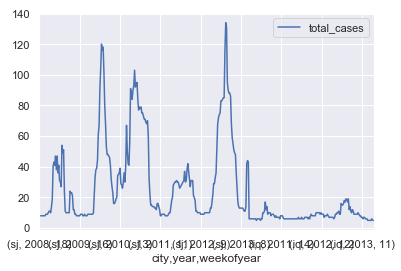

In [20]:
def submission( sj_predictions,iq_predictions):
    sj_predictions =  pd.Series(np.round(sj_predictions  ).round().astype(int) )
    iq_predictions =  pd.Series(np.round(iq_predictions )  .round().astype(int) )
    submission = pd.read_csv("./data/submission_format.csv", index_col=[0, 1, 2])
    submission.total_cases =np.concatenate([sj_predictions, iq_predictions])
   
    submission.to_csv("./data/submission_rf.csv")
    return submission
    
submission(sj_predictions ,iq_predictions).plot()

### XGBoost 

In [8]:
from xgboost import XGBRegressor
 
np.random.seed(10)
 
mdl_sj = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=1,
             importance_type='gain', learning_rate=0.02, max_delta_step=0,
             max_depth=2, min_child_weight=2, missing=None,  
             n_jobs=4, nthread=None, objective='reg:squarederror',
             random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)


mdl_sj.fit( train_X_sj ,train_y_sj.clip(0,300) )


mdl_iq = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=1,
             importance_type='gain', learning_rate=0.02, max_delta_step=0,
             max_depth=2, min_child_weight=2, missing=None,  
             n_jobs=4, nthread=None, objective='reg:squarederror',
             random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

mdl_iq.fit(train_X_iq  ,train_y_iq.clip(0,40))


sj_predictions =  pd.Series(np.round(mdl_sj . predict( test_X_sj)).astype(int) ) 
iq_predictions =  pd.Series(np.round(mdl_iq .predict(test_X_iq )).astype(int) ) 

 
 

D:\Anaconda3\envs\interview_env\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


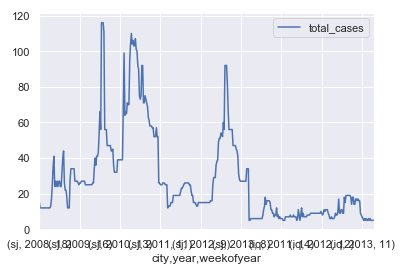

In [12]:
def submission( sj_predictions,iq_predictions):
    sj_predictions =  pd.Series(np.round(sj_predictions  ).round().astype(int) )
    iq_predictions =  pd.Series(np.round(iq_predictions )  .round().astype(int) )
    submission = pd.read_csv("./data/submission_format.csv", index_col=[0, 1, 2])
    submission.total_cases =np.concatenate([sj_predictions, iq_predictions])
   
    submission.to_csv("./data/submission_xgb.csv")
    return submission
    
submission(sj_predictions ,iq_predictions).plot()

In [13]:
xgb_pred = pd.read_csv("./data/submission_xgb.csv",index_col = [0,1,2])
rf_pred = pd.read_csv("./data/submission_rf.csv",index_col = [0,1,2])
ens_pred = np.round((xgb_pred+rf_pred)/2).astype(int)
ens_pred.to_csv("./data/submission_esb.csv")